In [1]:
!pip install timm
!pip install git+https://github.com/mapillary/inplace_abn.git@v1.0.12

     |████████████████████████████████| 346 kB 4.5 MB/s eta 0:00:01
  Cloning https://github.com/mapillary/inplace_abn.git (to revision v1.0.12) to /tmp/pip-req-build-n61op5ex
  Running command git clone -q https://github.com/mapillary/inplace_abn.git /tmp/pip-req-build-n61op5ex
  Running command git checkout -q 24fc791e6d4796a1639e7a5dce6fa67377e51a3e
  Created wheel for inplace-abn: filename=inplace_abn-1.0.12-cp37-cp37m-linux_x86_64.whl size=2756472 sha256=f3b046871d0d70c5331d2b87f0eeb599c3ddbc2dbf717d66956bb3568cd6b627
  Stored in directory: /tmp/pip-ephem-wheel-cache-pfy81jd9/wheels/df/ad/aa/7ec1eff8c9b56fb3fab10471e91c80bdf3b52036bf47727bae
Successfully built inplace-abn


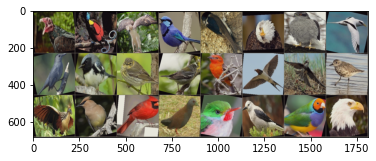

In [2]:
'''
We write this code with the help of PyTorch demo:
    https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
  

'''

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import timm
import random


RANDOM_SEED = 0

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


plt.ion()   # interactive mode

data_transforms = {
        'train': transforms.Compose([
        transforms.Resize((230,230)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ]),
        'valid': transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ]),
        'test': transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

data_dir = '../input/100-bird-species'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])

Showing 64 images when batch_size=64.

In [3]:
#model_ft = models.vgg11_bn(pretrained=True)
#num_ftrs = model_ft.classifier[0].in_features

model_ft = timm.create_model("tresnet_xl", pretrained=True)
num_ftrs = model_ft.head.fc.in_features

half_in_size = num_ftrs
layer_width = 1024
Num_class=275

class SpinalNetV1(nn.Module):
    def __init__(self):
        super(SpinalNetV1, self).__init__()
        self.dropout = nn.Dropout(p=0.2)      
        self.fc_spinal_layer1 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width*1, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width*2, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width*3, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width*4, Num_class),)
        
    def forward(self, x):
      x = x.view(x.size()[0], -1)
      xOrgD = self.dropout(x)
      x1 = self.fc_spinal_layer1(x)
      xOrgD = torch.cat([xOrgD, x1], dim=1)
      x2 = self.fc_spinal_layer2(xOrgD)
      xOrgD = torch.cat([xOrgD, x2], dim=1)
      x3 = self.fc_spinal_layer3(xOrgD)
      xOrgD = torch.cat([xOrgD, x3], dim=1)
      x4 = self.fc_spinal_layer4(xOrgD)
      x = torch.cat([xOrgD, x4], dim=1)
      x = self.fc_out(x)
      return x  
    

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model




'''
Changing the fully connected layer to SpinalNet or ResNet or VGG
'''

#model_ft.fc = nn.Linear(num_ftrs, Num_class)
model_ft.head.fc = SpinalNetV1() 

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tresnet/tresnet_xl_82_0-a2d51b00.pth" to /root/.cache/torch/hub/checkpoints/tresnet_xl_82_0-a2d51b00.pth


Loading pre-trained model from PyTorch.

In [4]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.6246 Acc: 0.6966
valid Loss: 0.1487 Acc: 0.9578
test Loss: 0.1209 Acc: 0.9695

Epoch 1/19
----------
train Loss: 0.2373 Acc: 0.9439
valid Loss: 0.0804 Acc: 0.9804
test Loss: 0.0564 Acc: 0.9833

Epoch 2/19
----------
train Loss: 0.1276 Acc: 0.9687
valid Loss: 0.0709 Acc: 0.9775

Epoch 3/19
----------
train Loss: 0.0848 Acc: 0.9801
valid Loss: 0.0548 Acc: 0.9869
test Loss: 0.0515 Acc: 0.9804

Epoch 4/19
----------
train Loss: 0.0568 Acc: 0.9865
valid Loss: 0.0411 Acc: 0.9891
test Loss: 0.0324 Acc: 0.9891

Epoch 5/19
----------
train Loss: 0.0403 Acc: 0.9900
valid Loss: 0.0482 Acc: 0.9884

Epoch 6/19
----------
train Loss: 0.0298 Acc: 0.9934
valid Loss: 0.0367 Acc: 0.9927
test Loss: 0.0407 Acc: 0.9862

Epoch 7/19
----------
train Loss: 0.0212 Acc: 0.9951
valid Loss: 0.0380 Acc: 0.9891

Epoch 8/19
----------
train Loss: 0.0170 Acc: 0.9966
valid Loss: 0.0336 Acc: 0.9920

Epoch 9/19
----------
train Loss: 0.0157 Acc: 0.9970
valid Loss: 0.0340 Acc: 0.9905



In [5]:
nb_classes = 275

valid_confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (valid_inputs, valid_classes) in enumerate(dataloaders['valid']):
        valid_inputs = valid_inputs.to(device)
        valid_classes = valid_classes.to(device)
        valid_outputs = model_ft(valid_inputs)
        _, valid_preds = torch.max(valid_outputs, 1)
        for t, p in zip(valid_classes.view(-1), valid_preds.view(-1)):
            valid_confusion_matrix[t.long(), p.long()] += 1

print(valid_confusion_matrix)

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.],
        [0., 0., 5.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 5., 0.],
        [0., 0., 0.,  ..., 0., 0., 4.]])


Text(0.5, 69.0, 'Predicted label')

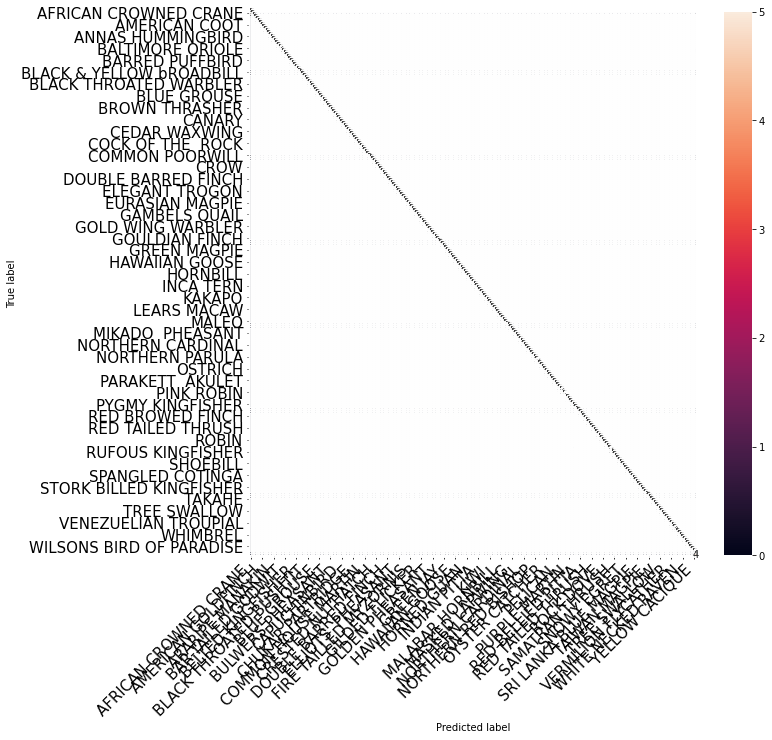

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

plt.figure(figsize=(10,10))
valid_class_names = list(image_datasets['valid'].classes)
valid_df_cm = pd.DataFrame(valid_confusion_matrix, index=class_names, columns=class_names).astype(int)
valid_heatmap = sns.heatmap(valid_df_cm, annot=True, fmt="d")

valid_heatmap.yaxis.set_ticklabels(valid_heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
valid_heatmap.xaxis.set_ticklabels(valid_heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [7]:
valid_recall = np.diag(valid_df_cm) / np.sum(valid_df_cm, axis = 1)
valid_precision = np.diag(valid_df_cm) / np.sum(valid_df_cm, axis = 0)
print("Recall")
print(valid_recall.mean())

print("\nPresisi")
print(valid_precision.mean())

Recall
0.9934545454545456

Presisi
0.9951731601731604


In [8]:
!pip install disarray

In [9]:
import disarray

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

print('accuracy: {:3f}'.format(accuracy(valid_confusion_matrix)))
print('precision: {:3f}'.format(valid_df_cm.da.precision.mean()))
print('recall: {:3f}'.format(valid_df_cm.da.recall.mean()))
print('f1: {:3f}'.format(valid_df_cm.da.f1.mean()))

accuracy: 0.993455
precision: 0.995173
recall: 0.993455
f1: 0.993250


In [10]:
#TEST
nb_classes = 275

test_confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (test_inputs, test_classes) in enumerate(dataloaders['test']):
        test_inputs = test_inputs.to(device)
        test_classes = test_classes.to(device)
        test_outputs = model_ft(test_inputs)
        _, test_preds = torch.max(test_outputs, 1)
        for t, p in zip(test_classes.view(-1), test_preds.view(-1)):
            test_confusion_matrix[t.long(), p.long()] += 1

print(test_confusion_matrix)

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.],
        [0., 0., 5.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 5., 0.],
        [0., 0., 0.,  ..., 0., 0., 5.]])


Text(0.5, 69.0, 'Predicted label')

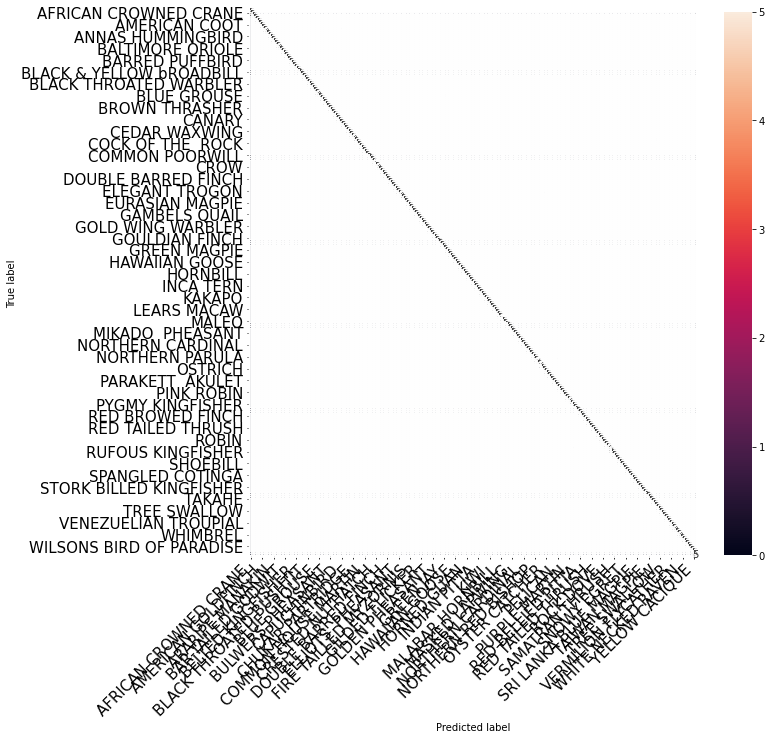

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
plt.figure(figsize=(10,10))
class_names = list(image_datasets['test'].classes)
test_df_cm = pd.DataFrame(test_confusion_matrix, index=class_names, columns=class_names).astype(int)
test_heatmap = sns.heatmap(test_df_cm, annot=True, fmt="d")
test_df_cm.to_csv('BTS1_TResNet_SpinalNet_test_confusion_matrix.csv')

test_heatmap.yaxis.set_ticklabels(test_heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
test_heatmap.xaxis.set_ticklabels(test_heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [12]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

test_recall = np.diag(test_df_cm) / np.sum(test_df_cm, axis = 1)
test_precision = np.diag(test_df_cm) / np.sum(test_df_cm, axis = 0)
print("Recall")
print(test_recall.mean())

print("\nPresisi")
print(test_precision.mean())

Recall
0.9876363636363638

Presisi
0.9903246753246754


In [13]:
print('accuracy: {:3f}'.format(accuracy(test_confusion_matrix)))
print('precision: {:3f}'.format(test_df_cm.da.precision.mean()))
print('recall: {:3f}'.format(test_df_cm.da.recall.mean()))
print('f1: {:3f}'.format(test_df_cm.da.f1.mean()))

accuracy: 0.987636
precision: 0.990325
recall: 0.987636
f1: 0.987517
